In [20]:
import sys
from pathlib import Path

exp_dir = str(Path("..").resolve())
if exp_dir not in sys.path:
    sys.path.insert(0, exp_dir)

In [21]:
from pathlib import Path

import numpy as np
import torch

# 사용자 모듈 임포트
from config import CONFIG
from xrr_model import XRR1DRegressor


class XRRInferenceEngine:
    def __init__(self, exp_dir=None):
        """
        추론 엔진 초기화: 설정 로드, 모델 로드, 통계 로드
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"[Inference] Device: {self.device}")

        # 1. 경로 설정
        if exp_dir is None:
            exp_dir = Path(CONFIG["base_dir"]) / CONFIG["exp_name"]
        else:
            exp_dir = Path(exp_dir)

        self.stats_file = exp_dir / "stats.pt"
        self.checkpoint_file = exp_dir / "best.pt"

        # 2. Master Grid 설정 (학습과 동일해야 함)
        self.q_min = CONFIG["simulation"].get("q_min", 0.0)
        self.q_max = CONFIG["simulation"].get("q_max", 0.5)
        self.n_points = CONFIG["simulation"].get("q_points", 200)

        # 모델이 바라보는 고정된 q축 생성
        self.target_q = np.linspace(self.q_min, self.q_max, self.n_points).astype(np.float32)

        # 3. 정규화 통계 로드
        if not self.stats_file.exists():
            raise FileNotFoundError(f"통계 파일이 없습니다: {self.stats_file}")

        stats = torch.load(self.stats_file, map_location=self.device)
        self.param_mean = stats["param_mean"]
        self.param_std = stats["param_std"]

        # 4. 모델 로드
        self._load_model()

    def _load_model(self):
        """모델 생성 및 가중치 로드"""
        if not self.checkpoint_file.exists():
            raise FileNotFoundError(f"체크포인트가 없습니다: {self.checkpoint_file}")

        # 체크포인트에서 모델 설정 가져오기 (없으면 Config 사용)
        ckpt = torch.load(self.checkpoint_file, map_location=self.device)
        model_args = ckpt.get('config', {}).get('model_args', {
            'q_len': self.n_points,
            'input_channels': 2, # [중요] 2채널 고정
            'n_channels': CONFIG["model"]["n_channels"],
            'depth': CONFIG["model"]["depth"],
            'mlp_hidden': CONFIG["model"]["mlp_hidden"],
        })

        self.model = XRR1DRegressor(**model_args).to(self.device)
        self.model.load_state_dict(ckpt['model_state_dict'])
        self.model.eval()
        print(f"[Inference] Model loaded from {self.checkpoint_file}")

    def preprocess(self, q_raw, R_raw):
        """
        Raw Data -> Model Input Tensor 변환
        (Dataset.__getitem__ 로직과 동일하게 구현)
        """
        # 1. Normalize R (Max Norm -> Log10)
        R_max = np.max(R_raw)
        R_norm = R_raw / (R_max + 1e-15)
        R_log = np.log10(np.maximum(R_norm, 1e-15))

        # 2. Interpolation (Master Grid로 내삽)
        # q_raw가 오름차순이어야 np.interp가 정확함
        if q_raw[0] > q_raw[-1]:
            q_raw = q_raw[::-1]
            R_log = R_log[::-1]

        R_interp = np.interp(self.target_q, q_raw, R_log, left=0.0, right=0.0)

        # 3. Masking
        q_valid_mask = (self.target_q >= np.min(q_raw)) & (self.target_q <= np.max(q_raw))

        # 4. Tensor 변환 & Stacking
        R_tensor = torch.from_numpy(R_interp.astype(np.float32))
        mask_tensor = torch.from_numpy(q_valid_mask.astype(np.float32))

        # Shape: (2, n_points)
        input_tensor = torch.stack([R_tensor, mask_tensor], dim=0)

        # Batch 차원 추가: (1, 2, n_points)
        return input_tensor.unsqueeze(0).to(self.device)

    def predict(self, q_raw, R_raw):
        """
        단일 데이터 추론 수행
        Returns: (thickness, roughness, sld) -> 실제 물리 단위
        """
        # 전처리
        x = self.preprocess(q_raw, R_raw)

        # 추론
        with torch.no_grad():
            # Output: (1, 3) -> Normalized Params
            y_pred_norm = self.model(x).squeeze(0)

        # 역정규화 (Denormalization)
        # Z-score 역변환: X = Z * Std + Mean
        y_pred = y_pred_norm * self.param_std + self.param_mean

        # Tensor -> Numpy / List 변환
        return y_pred.cpu().numpy()


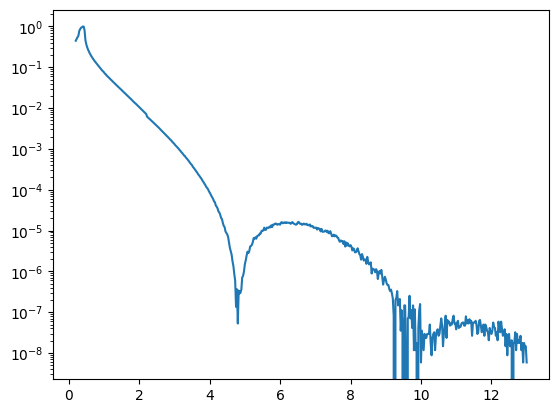

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

from reflecto.simulate.simul_genx import ParamSet

file = r"D:\03_Resources\Data\XRR_AI\XRR_data\QGMOG029_02_0.2_13_final.dat"
df = pd.read_csv(file, header=None, sep=r"\s+", names=["tth", "R"])

tth_measured = df["tth"].to_numpy()
refl = df["R"].to_numpy()
refl = refl / refl.max()
# refl = refl / refl[0]
plt.plot(tth_measured, refl)
plt.yscale("log")

In [23]:
from reflecto.simulate.simul_genx import tth2q_wavelen
from reflecto.simulate.simul_genx import params2refl
engine = XRRInferenceEngine(exp_dir=r"D:\03_Resources\Data\XRR_AI\data\one_layer\mask")

# 2. 가상의 측정 데이터 (예시: qs와 true_refl이 있다고 가정)
# 실제 상황에서는 qs, true_refl = load_my_data()
print("\n--- Single Data Prediction ---")

# 테스트용 더미 데이터 생성 (사용자 데이터로 교체하세요)
test_q = tth2q_wavelen(tth_measured)
test_R = refl

# 3. 예측 실행
thickness_pred, roughness_pred, sld_pred = engine.predict(test_q, test_R)
param = ParamSet(thickness_pred, roughness_pred, sld_pred)

print("Predicted Parameters:")
print(f"  Thickness: {thickness_pred:.4f} Å")
print(f"  Roughness: {roughness_pred:.4f} Å")
print(f"  SLD:       {sld_pred:.4e} (10^-6 Å^-2)")

[Inference] Device: cuda
[Inference] Model loaded from D:\03_Resources\Data\XRR_AI\data\one_layer\mask\best.pt

--- Single Data Prediction ---
Predicted Parameters:
  Thickness: 8.9886 Å
  Roughness: 4.3434 Å
  SLD:       1.3926e+01 (10^-6 Å^-2)


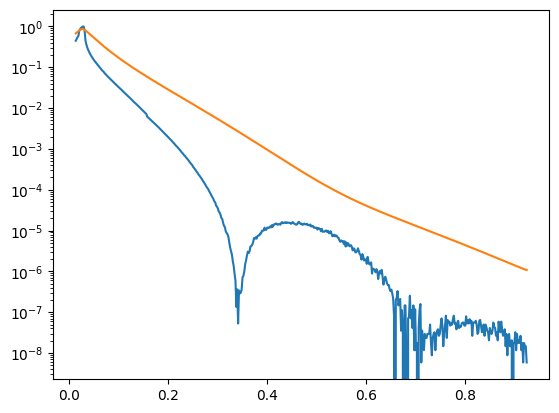

In [24]:
param = ParamSet(thickness_pred, roughness_pred, sld_pred)
sim_refl = params2refl([param], test_q)

plt.plot(test_q, refl)
plt.plot(test_q, sim_refl)
plt.yscale("log")

plt.show()

In [25]:
import numpy as np
from genx.data import DataList, DataSet
from genx.model import Model
from genx.parameters import Parameters
from genx import fom_funcs

# 1) 측정 데이터 준비
qz = test_q
R  = refl
dR = np.maximum(refl*0.3, 1e-8)

ds = DataSet(name="XRR 1-layer")
ds.x_raw = qz
ds.y_raw = R
ds.error_raw = dR
ds.run_command()

data = DataList([ds])

# 2) 스크립트 작성
# [수정 1] param.sld가 어떤 단위인지 모르겠지만, 
# script 내부에는 "10^-6 A^-2" 단위의 숫자(예: 2.0, 18.5)로 넘기는 것이 좋습니다.
# 여기서는 param.sld가 1e-6 단위라고 가정하고 그대로 넣습니다.
script_text = rf"""
from genx.models.spec_nx import Sample, Stack, Layer, Instrument, Specular
from genx.models.spec_nx import Probe, Coords, ResType, FootType
# [핵심] 물리 상수 r_e (2.8179e-5) 가져오기
from genx.models.lib.physical_constants import r_e 

# 초기값 (단위: 10^-6 A^-2 로 통일)
initial_thickness = {param.thickness}
initial_roughness = {param.roughness}
initial_sld       = {param.sld}       # 예: 2.07

SI_SLD_VAL = 2.07 # 기판 SLD (10^-6 A^-2 단위)
initial_I0 = 1.0

class Vars:
    def __init__(self, d, sigma, sld, i0):
        self._d = float(d)
        self._sigma = float(sigma)
        self._sld = float(sld)
        self._i0 = float(i0)
    def set_thickness(self, v): self._d = float(v)
    def get_thickness(self):    return self._d
    def set_roughness(self, v): self._sigma = float(v)
    def get_roughness(self):    return self._sigma
    def set_sld(self, v):       self._sld = float(v)
    def get_sld(self):          return self._sld
    def set_I0(self, v):        self._i0 = float(v)
    def get_I0(self):           return self._i0

vars = Vars(initial_thickness, initial_roughness, initial_sld, initial_I0)

# [핵심] SLD -> f 변환 함수
# GenX X-ray: SLD = dens * f * r_e
# 따라서 f = SLD_real / (dens * r_e)
def get_f_from_sld(sld_1e6):
    # 입력: 10^-6 단위 (예: 2.07) -> 실제값 2.07e-6
    real_sld = sld_1e6 * 1e-6
    # dens를 1.0으로 고정하고 f를 계산
    return real_sld / r_e

Amb = Layer(d=0.0, dens=0.0, f=0.0)

# 기판: 변환 함수 적용
Sub = Layer(d=0.0, f=get_f_from_sld(SI_SLD_VAL), dens=1.0, sigma=3.0)

# 박막: 초기값으로 설정 (Sim 호출 시 업데이트됨)
Film = Layer(d=vars.get_thickness(),
             sigma=vars.get_roughness(),
             f=get_f_from_sld(vars.get_sld()),
             dens=1.0)

# 표면층 (옵션)
SURFACE_SIO2 = Layer(
    d=15.0,
    f=complex(14, 0.1), # 이건 원자 단위(Si=14)로 쓴 것 같네요. dens=0.05와 결합됨.
    dens=0.05,
    sigma=2.0
)

sample = Sample(Stacks=[Stack(Layers=[SURFACE_SIO2, Film])], Ambient=Amb, Substrate=Sub)

inst = Instrument(
    probe=Probe.xray,
    wavelength=1.54,
    coords=Coords.q,
    I0=vars.get_I0(),
    Ibkg=1e-10,
    res=0.005,
    restype=ResType.fast_conv,
    footype=FootType.gauss
)

def _sync():
    Film.d     = vars.get_thickness()
    Film.sigma = vars.get_roughness()
    # [핵심] 여기서도 변환 함수 사용 (일관성 유지)
    Film.f     = get_f_from_sld(vars.get_sld())
    inst.I0    = vars.get_I0()

def Sim(data):
    _sync()
    return [Specular(di.x, sample, inst) for di in data]
"""

# 3) 모델 생성 및 컴파일
model = Model()
model.data = data
model.set_script(script_text)
model.compile_script()

# 4) 파라미터 등록
pars = Parameters()

p_thick = pars.append("vars.set_thickness", model)
p_thick.value = param.thickness
p_thick.fit = True

p_rough = pars.append("vars.set_roughness", model)
p_rough.value = param.roughness
p_rough.fit = True

# [수정 2] SLD 파라미터 설정
p_sld = pars.append("vars.set_sld", model)
# 여기서 param.sld가 만약 2.07e-6 (실제값)이라면 -> 2.07로 변환해서 넣기
# 만약 param.sld가 이미 2.07이라면 그대로 넣기.
# (사용자 데이터에 따라 맞춰주세요. 여기서는 1e6을 곱해서 보기 편한 숫자로 만듦)
p_sld.value = param.sld if param.sld > 1 else param.sld * 1e6 
p_sld.fit = True

p_i0 = pars.append("vars.set_I0", model)
p_i0.value = 1.0
p_i0.min = 0.1
p_i0.max = 10.0
p_i0.fit = False

model.parameters = pars

# ---------------------------------------------------------
# [단계 1] I0 피팅
# ---------------------------------------------------------
print("--- Step 1: Fitting I0 ---")
model.set_fom_func(fom_funcs.diff)
res_i0 = model.bumps_fit(method="dream", steps=200) # 가볍게 DE 사용
model.bumps_update_parameters(res_i0)
print(f"Fitted I0: {p_i0.value}")

# ---------------------------------------------------------
# [단계 2] 전체 피팅
# ---------------------------------------------------------
print("--- Step 2: Full Fitting ---")
model.set_fom_func(fom_funcs.log)

p_thick.fit = True
p_rough.fit = True
p_sld.fit   = True
p_i0.fit    = False # I0 고정

# Newton은 국소 최적화라 초기값이 나쁘면 발산할 수 있습니다. 'de' 추천.
res_final = model.bumps_fit(method="dream", steps=1000, pop=20, tol=0.01) 
model.bumps_update_parameters(res_final)

model.evaluate_sim_func()
print("Final Results:")
for par in model.parameters:
    print(f"  {par.name} = {par.value}")

--- Step 1: Fitting I0 ---
Fitted I0: 1.0
--- Step 2: Full Fitting ---
Final Results:
   = 0.0
  vars.set_thickness = 4.284598161968189
  vars.set_roughness = 1.0860649363447412
  vars.set_sld = 14.032045736492176
  vars.set_I0 = 1.0


d:\02_Projects\Dev\X-ray_AI\Reflecto\.venv\Lib\site-packages\genx\fom_funcs.py:215: RuntimeWarning: divide by zero encountered in log10
  return [(np.log10(dataset.y) - np.log10(sim)) for (dataset, sim) in zip(data, simulations)]


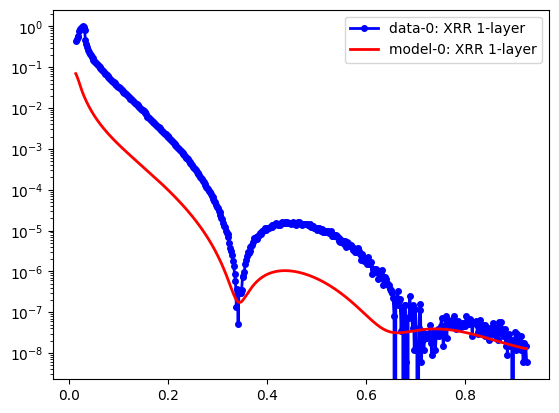

In [26]:
from genx.diffev import DiffEv
from genx.model_control import ModelController

controller = ModelController(DiffEv())
controller.set_model(model)
controller.StartFit()

fitted = controller.get_fitted_model()
fitted.simulate()
fitted.data.plot()
plt.show()

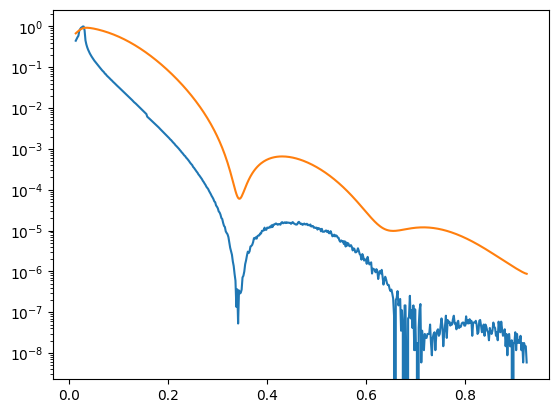

In [27]:
param = ParamSet(20, 3, sld_pred)
sim_refl = params2refl([param], test_q)

plt.plot(test_q, refl)
plt.plot(test_q, sim_refl)
plt.yscale("log")

plt.show()